In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
drive_path = '/content/drive/My Drive'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
processed_data_file = drive_path + '/1_processed_data'
os.path.exists(processed_data_file)

True

In [96]:
tot_train_df = pd.read_csv(processed_data_file+'/train_PCA_data.csv')#,index_col=0)

In [102]:
tot_train_df.head()

,id,cycle,s2,s3,s4,s7,s11,s12,s15,RUL,HI
0,1,1,-1.043976,-0.402325,-0.735593,0.922429,-0.713047,1.045859,-0.735619,191,-2.126821
1,1,2,-1.013039,-0.437787,-0.744731,0.927522,-0.754362,1.056043,-0.759942,190,-2.163152
2,1,3,-0.961467,-0.495099,-0.765407,0.933752,-0.825635,1.067335,-0.801976,189,-2.223635
3,1,4,-0.905369,-0.553770,-0.799936,0.934785,-0.909588,1.066562,-0.851178,188,-2.289392
4,1,5,-0.860195,-0.596473,-0.847359,0.924675,-0.990531,1.043267,-0.896681,187,-2.342838


In [103]:
tot_cycles = pd.DataFrame([len(tot_train_df[tot_train_df['id'] == idx]) for idx in tot_train_df['id'].unique()],columns =['tot_cycle'])
tot_cycles['rul_label'] = pd.DataFrame(pd.qcut(tot_cycles['tot_cycle'],4, labels=['1','2','3','4']))
tot_cycles.index = tot_train_df['id'].unique()#range(1,101)

In [105]:
tot_cycles

,tot_cycle,rul_label
1,192,2
2,287,4
3,179,2
4,189,2
5,269,4
...,...,...
96,336,4
97,202,3
98,156,1
99,185,2


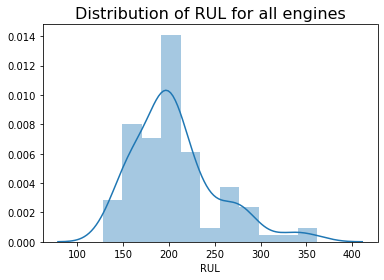

In [31]:
#ax=sns.distplot(rul_y)
ax=sns.distplot(tot_cycles['tot_cycle'])
ax.set_title('Distribution of RUL for all engines',{'fontsize':16});
ax.set_xlabel('RUL');

In [110]:
random_state = 1
tot_train_id = tot_train_df['id'].unique()
# stratify 按照数据分布进行划分
train_id, test_id = train_test_split(tot_train_id, test_size = 0.2, random_state=random_state, stratify = tot_cycles['rul_label'])
train_df = tot_train_df[tot_train_df['id'].isin(train_id)]
test_df = tot_train_df[tot_train_df['id'].isin(test_id)]

In [108]:
train_id

array([ 10,   6,  93,  44,  84,  92,  34,  12,  23,  78,  27,  90,  54,
        33,  19,  13,  18,  71,  58,  73,  35,  15,  79,   3,  56,  75,
        96,   8,  87,   9,   1,  86,  37,  63,  22,   5,  25,  50,  72,
        82,  51,  61,  40,  88,  47,   7,  21,  98,  52,  53,  95,  57,
        28,  68,   2,  30,  67,   4,  83,  81,  60,  69,  38,  77,  91,
        66,  89,  94,  26,  62,  99, 100,  64,  74,  85,  65,  59,  49,
        70,  46])

In [111]:
train_df.head()

,id,cycle,s2,s3,s4,s7,s11,s12,s15,RUL,HI
0,1,1,-1.043976,-0.402325,-0.735593,0.922429,-0.713047,1.045859,-0.735619,191,-2.126821
1,1,2,-1.013039,-0.437787,-0.744731,0.927522,-0.754362,1.056043,-0.759942,190,-2.163152
2,1,3,-0.961467,-0.495099,-0.765407,0.933752,-0.825635,1.067335,-0.801976,189,-2.223635
3,1,4,-0.905369,-0.553770,-0.799936,0.934785,-0.909588,1.066562,-0.851178,188,-2.289392
4,1,5,-0.860195,-0.596473,-0.847359,0.924675,-0.990531,1.043267,-0.896681,187,-2.342838


In [129]:
# pick a large window size of 50 cycles

# function to reshape features into (samples, time steps, features) 
# 生成特征样本
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones 
    只有比时间窗口大的序列会被提取特征，若测试样本的时间序列过小，则被忽视。
    另一种方法是对序列进行填充
    """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values # 获得对应列的值
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 141 to 191
    
    # zip将数据打包为元组的列表
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :].flatten() #yield 相当于返回

In [121]:
# TODO for debug 
# 样例测试
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 18 columns)
sequence_length = 50
sequence_cols = ['HI','s2']
val=list(gen_sequence(tot_train_df.loc[1], sequence_length, sequence_cols))
print(len(val))

0


In [ ]:
list(seq_gen)

In [132]:
# 对每个发动机生成训练样本
# generator for the sequences
# transform each id of the train dataset in a sequence
win_size = 50
selected_ftr_name = ['HI']
train_seq_gen = (list(gen_sequence(tot_train_df[tot_train_df['id']==id], win_size, selected_ftr_name)) 
           for id in train_id)
# generate sequences and convert to numpy array
X_train = np.concatenate(list(train_seq_gen)).astype(np.float32)

In [133]:
X_train.shape

(12673, 50)

In [134]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [175]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
y_train = np.concatenate(label_gen).astype(np.float32).ravel()
y_train.shape

#y_train = np.array(list(gen_labels(tot_train_df.loc[train_id], win_size, ['RUL'])) ).ravel()
#y_valid = np.array(list(gen_labels(tot_train_df.loc[test_id], win_size, ['RUL'])) ).ravel()

(12673,)

In [174]:
y_train.shape

(12673, 1)

In [142]:
cut_percents = [0.5,0.7,0.9]

In [167]:
X_test = [];
for idx in test_id:
  tmp_df = test_df[test_df['id'] == idx]
  for cut_per in cut_percents:
    tmp_cur = int(len(tmp_df)*cut_per)
    X_test += [np.array(tmp_df[tmp_cur - win_size: tmp_cur][selected_ftr_name]).flatten()]
X_test = np.array(X_test)

In [168]:
X_test.shape

(60, 50)

In [179]:
params = {
    'kernel':('linear', 'rbf'),
    "C": [1e0, 1e1, 1e2, 1e3],
    "gamma": [0.1, 0.125, 0.25, 0.5, 1, 2, 4]
}
svr = GridSearchCV(SVR(kernel = 'rbf'), cv=5, param_grid= params, scoring = 'neg_root_mean_squared_error', verbose = 1)

In [ ]:
svr.best_params_

{'C': 10.0, 'gamma': 0.1}

In [ ]:
t0 = time.time()
#训练
svr.fit(X_train, y_train)
svr_fit = time.time() - t0

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:

t0 = time.time()
#测试
y_svr = svr.predict(X_valid)
svr_predict = time.time() - t0


In [ ]:
np.sqrt(sum((y_svr - y_valid)**2))

1841.4660959658122

In [44]:
model_file = drive_path + '/2_saved_model'
if os.path.exists(model_file)==False:
    os.makedirs(model_file)

In [ ]:
import pickle 
f = open(model_file + '/svr.pickle','wb')
pickle.dump(svr, f)
f.close()

In [ ]:
f = open(model_file + '/svr.pickle','rb')
clf = pickle.load(f)
f.close()

In [ ]:
clf.best_params_

{'C': 10.0, 'gamma': 0.1}

In [ ]:
cut_percents = [0.5,0.7,0.9]
res_info_col = ['on_id','on_seg','y_pred','y_true']
res_df = pd.DataFrame(columns=res_info_col)
for on_id in test_id:
    n_seg = len(test_df.loc[on_id])
    for cut_per in cut_percents:
        cur_seg = int(n_seg * cut_per/10)*10 - on_win_size
        tmp_df = eu_dist_df[(eu_dist_df['on_id']==on_id) &(eu_dist_df['on_seg']==cur_seg)].sort_values(by='dist')[:k]
        tmp_rul = sum(tmp_df['his_RUL']*np.exp(-alpha * tmp_df['dist'])/sum(np.exp(-alpha * tmp_df['dist'])))
        #print(cur_seg,tmp_rul, cur_seg+tmp_rul, n_seg - cur_seg - on_win_size)
        res_df= res_df.append(pd.DataFrame([[on_id, cur_seg, tmp_rul, n_seg -cur_seg - on_win_size]],columns = res_info_col))
eu_score += [(k, alpha, RHS_score( res_df['y_true'], res_df['y_pred'])/len(res_df['y_pred']))]